## Dataset Description

**Name:** IoT-Based Environmental Dataset

**Source:** [Kaggle - IoT-Based Environmental Dataset](https://www.kaggle.com/datasets/ziya07/iot-based-environmental-dataset?resource=download)

**Summary:**  
This dataset provides detailed environmental and mental health data collected from a university setting using IoT sensors. It includes environmental metrics such as temperature, humidity, air quality, noise, lighting, and crowd density, as well as student-reported mental health indicators like stress level, sleep hours, mood score, and mental health status. The goal is to analyze how environmental conditions may influence students' well-being.

**Structure:**  
- Each row represents a 15-minute interval of environmental readings (e.g., temperature, noise, air quality) from various campus locations.
- The dataset contains 1000 rows and 12 columns.
- The dataset contains the following columns:

| Column Name   | Description                                      |
|---------------|--------------------------------------------------|
| timestamp	| Time of environmental reading data capture (format: YYYY-MM-DD HH:MM:SS) |
| location_id | Identifier where sensors are deployed (values range from 101-105) |
| temperature_celsius |	Ambient temperature in Celsius |
| humidity_percent | Relative humidity percentage |
| air_quality_index | Air quality measurement (higher values indicate poorer air quality) |
| noise_level_db | Noise level in decibels |
| lighting_lux | Illumination intensity in lux |
| crowd_density | Number of people in the area |
| stress_level | Modeled student stress score (0–100) |
| sleep_hours | Estimated sleep duration in hours |
| mood_score | Modeled emotional score ranging from -3 (very negative) to +3 (very positive) |
| mental_health_status | Categorical indicator (0 = Normal, 1 = Mild Risk, 2 = At Risk) |

**Provenance:**  
Compiled and published by Ziya on Kaggle. Last updated in 2025.

**License:**  
Check the Kaggle page for licensing details; the dataset is typically available for educational and non-commercial use.

**Note:**  
- The location_id column refers to the specific IoT sensor or monitored area within the university environment.
- The dataset was likely compiled from various environmental sensors and self-reported student responses, then structured into a CSV file.
- mental_health_status is a simplified binary label and may not capture the full complexity of a student's psychological condition.

**Potential Implications and Biases:**
- Since the data involves self-reported mental health metrics, responses may be subject to personal bias, underreporting, or overestimation.
- Sensor accuracy and calibration may affect the consistency and precision of environmental measurements (e.g., noise or air quality).
- The dataset is limited to a university population and may not generalize to broader demographic or institutional contexts.
- Environmental conditions are highly dynamic, and snapshots in time may not fully capture long-term exposure or effects.

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

mental_health_df = pd.read_csv('university_mental_health_iot_dataset.csv')
mental_health_df.shape

(1000, 12)

**The dataset contains 1000 observations through the pandas 'shape' attribute.**

## Target Research Questions

**1. To what extent do environmental factors (temperature, humidity, air quality, noise, lighting, crowd density) predict student stress levels, and which factors have the strongest relationship?**

EDA: 
1. What is the correlation between each environmental factor and student stress levels?
2. Which environmental factor has the strongest relationship with stress levels?
3. Are there any non-linear relationships between environmental factors and stress?
4. Do certain locations consistently show higher stress levels regardless of environmental conditions?

**2. How does sleep duration vary with environmental conditions, and can specific environmental thresholds be identified that significantly impact student sleep patterns?**

EDA: 
1. How does sleep duration vary across different levels of environmental stressors?
2. What distinct environmental-sleep pattern clusters emerge from the data, and what characterizes each cluster?
3. Does sleep duration differ across different campus locations?

**3. What combination of environmental conditions differentiates locations with higher rates of mental health risk (status 1-2) from those with predominantly normal status (0), and can these patterns inform university space design?**

EDA: 
1. What are the average values of environmental variables in locations where mental health status is at risk (1) vs. normal (0)?
2. Which locations have the highest proportion of at-risk mental health statuses?
3. What are two specific combinations of environmental factors that are consistently associated with at-risk mental health status?
4. Which environmental conditions often happen together in places where students are mostly at risk (mental health status 1 or 2)?

## Data Preprocessing
Our data preprocessing approach ensures that the dataset is accurate, consistent, and fully prepared for analysis. We started by inspecting the data for missing values and duplicates, confirming that the dataset is complete and unique. Next, we standardized numerical precision across relevant columns, rounding values to appropriate decimal places to enhance consistency and interpretability. We also converted key columns—such as timestamps and categorical variables—to their correct data types, enabling more effective time-based and group analyses. Outlier detection was performed using summary statistics, allowing us to identify any unusual or potentially problematic values. Each transformation was carefully documented and verified, resulting in a clean and reliable dataset that provides a solid foundation for meaningful exploratory analysis and modeling.

It is noticed that the decimal inconsistency in the specified columns: **temperature_celsius**, **humidity_percent**, **noise_level_db**, and **sleep_hours** constitutes a data integrity issue affecting numerical precision and standardization. Through data cleaning, specifically rounding to uniform decimal digits the dataset’s quality, reliability, and analytical value are significantly enhanced.

The function **'min_decimal_places'** is used to identify the lowest number of decimal digits present within each specified column. This lowest decimal digit is then applied uniformly to all values in the column, ensuring consistent decimal formatting. Such standardization improves data integrity and facilitates accurate analysis.

In [33]:
def min_decimal_places(series):
    series = series.dropna()
    decimals = series.astype(str).apply(
        lambda x: len(x.split('.')[-1]) if '.' in x else 0
    )
    return decimals.min()

The function **'implement_min_decimal'** is used to implement the data cleaning basing on the returned number of decimal digits from 'min_decimal_places' function and then rounded off if the min_decimal_places value is < than the data's decimal value

In [34]:
def implement_min_decimal(column):
    cleaned_column = column.round(min_decimal_places(column))
    return cleaned_column

**Implementation of the funtions to the columns**

In [35]:
# List of columns to clean (excluding mood_score and mental_health_status if not needed)
columns_to_clean = [
    'temperature_celsius', 'humidity_percent', 'noise_level_db', 'sleep_hours'
]

# Apply implement_min_decimal to each column in the list
for col in columns_to_clean:
    mental_health_df[col] = implement_min_decimal(mental_health_df[col])

# Verification for cleaned columns
print(mental_health_df[columns_to_clean].head(10))

   temperature_celsius  humidity_percent  noise_level_db  sleep_hours
0            24.328184         62.987529       54.429034          7.2
1            26.177300         52.482089       62.336451          5.0
2            25.443028         55.736424       51.967691          5.0
3            24.671652         71.484457       54.658851          8.2
4            21.628577         61.132704       60.623440          6.6
5            25.414405         45.617220       51.121999          6.5
6            29.646073         69.192289       52.022026          7.6
7            28.036260         53.318559       43.232965          9.7
8            28.779560         78.732978       54.850632          5.8
9            22.466353         70.800481       51.651515          7.6


**Lighting Lux Standardization**

To ensure consistency and interpretability, we round the **lighting_lux** values to the nearest integer. Lux, as a unit of light intensity, is almost always measured and reported as a whole number in both sensor outputs and practical applications. This step removes insignificant decimal places, making the data cleaner and easier to analyze without sacrificing any meaningful information.

In [36]:
mental_health_df['lighting_lux'] = mental_health_df['lighting_lux'].round(0).astype(int)

**Categorical Variable Conversion**

We convert the **location_id** and **mental_health_status** columns to categorical data types. This not only optimizes memory usage but also clarifies the nature of these variables as discrete categories rather than continuous numbers. Properly encoding categorical variables is essential for accurate analysis and modeling, especially when performing group-based operations or preparing data for machine learning algorithms.



In [37]:
mental_health_df['location_id'] = mental_health_df['location_id'].astype('category')
mental_health_df['mental_health_status'] = mental_health_df['mental_health_status'].astype('category')

**Timestamp Parsing**

We convert the **timestamp** column from string format to a datetime object. This transformation enables us to perform time-based analyses, such as identifying trends over specific periods, aggregating data by hour or day, and visualizing temporal patterns. Accurate datetime formatting is foundational for any analysis involving time series or temporal relationships.

In [38]:
mental_health_df['timestamp'] = pd.to_datetime(mental_health_df['timestamp'])

**Missing Values and Duplicate Checks**

Before further processing, we check for missing values and duplicate rows in the dataset. Addressing these issues at the outset prevents potential biases and errors in our analysis. If any are found, we can decide whether to impute, remove, or otherwise handle them based on the context and extent of the issue.

In [39]:
print(mental_health_df.isna().sum())
print(mental_health_df.duplicated().sum())

timestamp               0
location_id             0
temperature_celsius     0
humidity_percent        0
air_quality_index       0
noise_level_db          0
lighting_lux            0
crowd_density           0
stress_level            0
sleep_hours             0
mood_score              0
mental_health_status    0
dtype: int64
0


**Result:** 
 
The output above shows that there are **no missing values** and **no duplicate rows** in the dataset. This confirms that the data is complete and unique, allowing us to proceed confidently with further analysis.

**Outlier Detection**

We examine summary statistics and visualizations for each numerical column to identify potential outliers or anomalous values. Detecting and addressing outliers is crucial, as they can disproportionately influence statistical analyses and model performance. Depending on the findings, we may choose to investigate, correct, or exclude these values from further analysis.

In [40]:
print(mental_health_df.describe())

                 timestamp  temperature_celsius  humidity_percent  \
count                 1000          1000.000000       1000.000000   
mean   2024-05-06 12:52:30            24.208457         60.189320   
min    2024-05-01 08:00:00            15.235949         29.804878   
25%    2024-05-03 22:26:15            22.183079         53.726462   
50%    2024-05-06 12:52:30            24.168562         60.048989   
75%    2024-05-09 03:18:45            26.125555         66.726456   
max    2024-05-11 17:45:00            33.579323         91.377485   
std                    NaN             3.012801          9.747296   

       air_quality_index  noise_level_db  lighting_lux  crowd_density  \
count        1000.000000     1000.000000    1000.00000    1000.000000   
mean           85.446000       54.722387     301.49300      31.736000   
min            20.000000       24.540712     155.00000       5.000000   
25%            51.000000       47.853538     267.00000      18.000000   
50%          

**Outlier Handling**

After identifying potential outliers using summary statistics, we proceed to handle them to ensure they do not unduly influence our analysis. We use the Interquartile Range (IQR) method to detect outliers for each numerical column. Values lying below Q1 - 1.5*IQR or above Q3 + 1.5*IQR are considered outliers. We will flag these outliers and, for this analysis, remove them to maintain data integrity.

In [41]:
# List of numerical columns to check for outliers
num_cols = [
    'temperature_celsius', 'humidity_percent', 'air_quality_index',
    'noise_level_db', 'lighting_lux', 'crowd_density',
    'stress_level', 'sleep_hours', 'mood_score'
]

# Function to remove outliers using IQR
def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        before = df.shape[0]
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        after = df.shape[0]
        print(f"{col}: Removed {before - after} outliers")
    return df

# Remove outliers
mental_health_df = remove_outliers_iqr(mental_health_df, num_cols)

# Show the new shape of the cleaned dataset
print("New dataset shape after outlier removal:", mental_health_df.shape)

temperature_celsius: Removed 8 outliers
humidity_percent: Removed 11 outliers
air_quality_index: Removed 0 outliers
noise_level_db: Removed 7 outliers
lighting_lux: Removed 7 outliers
crowd_density: Removed 0 outliers
stress_level: Removed 1 outliers
sleep_hours: Removed 7 outliers
mood_score: Removed 3 outliers
New dataset shape after outlier removal: (956, 12)


**Result**  
Outliers have been removed from the dataset using the IQR method for each numerical column. The updated dataset is now less likely to be influenced by extreme values, ensuring more robust and reliable analysis in subsequent steps.

With the dataset reduced from 1,000 to 956 observations. This represents a retention rate of 95.6% of the original data, which is well within acceptable limits for statistical analysis. The small reduction of only 44 observations (4.4%) ensures that the dataset maintains its representativeness while significantly improving data quality and reliability. This level of data retention preserves the statistical power needed for robust analysis while eliminating extreme values that could potentially skew results and compromise the validity of our findings.

## __RESEARCH QUESTION 1:__ To what extent do environmental factors (temperature, humidity, air quality, noise, lighting, crowd density) predict student stress levels, and which factors have the strongest relationship?

EDA:

### __1.1 What is the correlation between each environmental factor and student stress levels?__
The researchers conducted a Pearson Correlation to explore the relationshop levels between each environmental factor and stress levels of students. A heatmap was also utilized to visualize each factor's relationship

The first step is to define the environment variables present in the dataset. The next steps were to create a correlation matrix using the cleaned dataframe, then extract the column of correlations with "stress_level" from the matrix and sorting it in descending order.

In [42]:
env_vars = [
    "temperature_celsius", "humidity_percent", "air_quality_index",
    "noise_level_db", "lighting_lux", "crowd_density"
]

# Correlation matrix
corr_matrix = mental_health_df[env_vars + ["stress_level"]].corr()

corr_matrix['stress_level'].sort_values(ascending=False)

stress_level           1.000000
air_quality_index      0.556982
noise_level_db         0.241990
crowd_density          0.218813
lighting_lux           0.014253
humidity_percent      -0.006092
temperature_celsius   -0.049258
Name: stress_level, dtype: float64

The next part is to generate a heatmap that shows how each environmental variable relates to stress level and to each other.

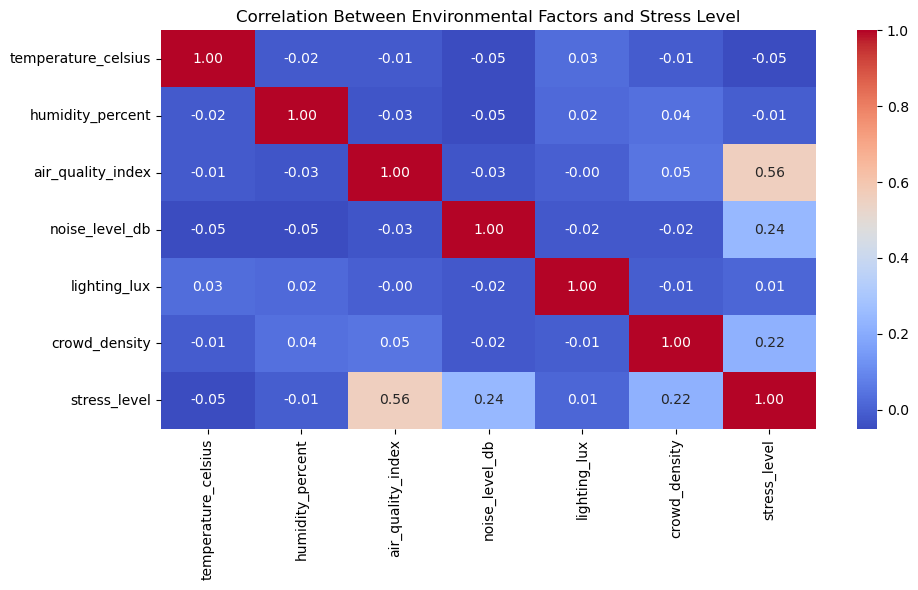

In [43]:
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Environmental Factors and Stress Level")
plt.tight_layout()
plt.show()

The correlation matrix suggests the following relationships between student stress levels and  and environmental factors:

- Stress level has a moderate positive correlation with air quality index.
- Stress level has a weak positive correlation with noise level, crowd density, and lighting lux.
- Stress level has a weak negative correlation with humidity percentage and temperature.

### __1.2 Which environmental factor has the strongest relationship with stress levels?__

This indicates that air quality index may have a modest influence on a student's stress level, while attributes like noise level, crowd density, and lighting lux have a weaker influence. The weak negative correlation with humidity percentage and temparature may indicate that a lower humidity and temperature can have a weak influence on students' stress levels.

### __1.3 Are there any non-linear relationships between environmental factors and stress?__

The code below creates a for loop for all the environment variables in env_var and creating a scatter plot with a LOWESS smoothed trend line for each variable.

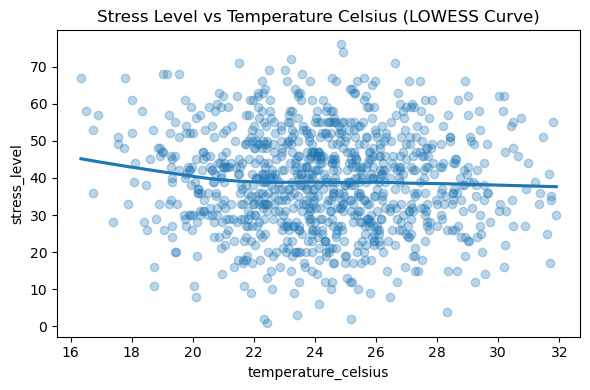

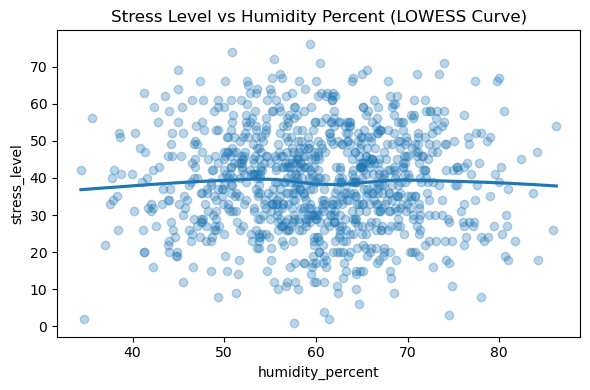

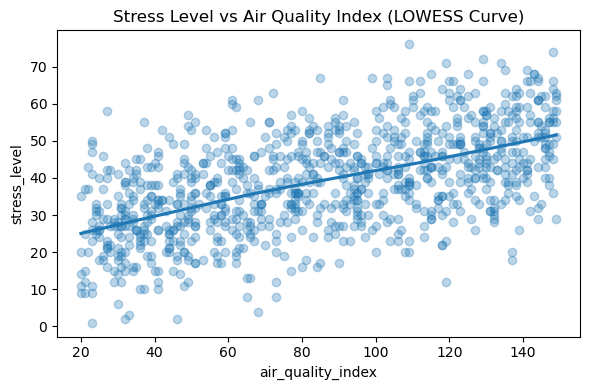

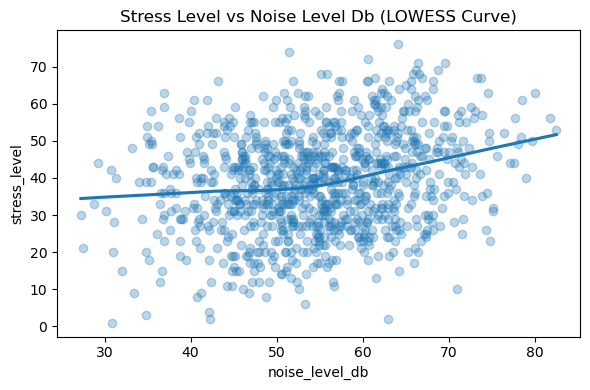

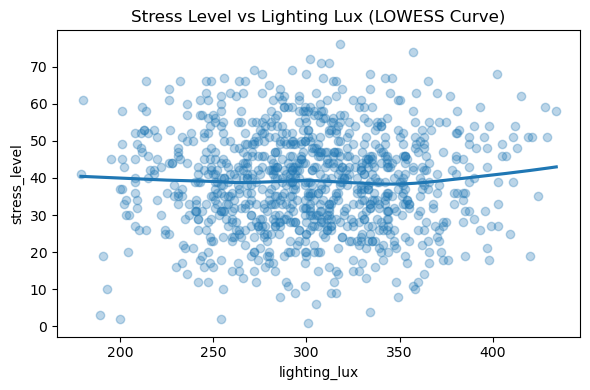

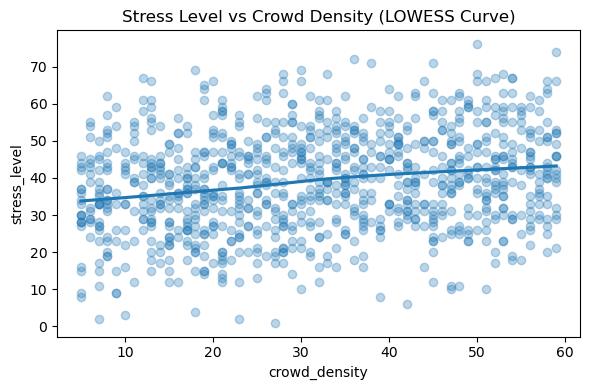

In [44]:
for var in env_vars:
    plt.figure(figsize=(6, 4))
    sns.regplot(data=mental_health_df, x=var, y="stress_level", lowess=True, scatter_kws={'alpha':0.3})
    plt.title(f"Stress Level vs {var.replace('_', ' ').title()} (LOWESS Curve)")
    plt.tight_layout()
    plt.show()

To answer this question, evnironmental factors in the dataset were indivudually correlated with stress levels and were visualized using scatterplots. The results show that air quality index and stress levels have a somewhat linear relationship, suggesting a quite upward trend. The researchers looked into this further by checking the (individual) pearson corrlation and spearman correlation of this relationship 

In [45]:
from scipy.stats import spearmanr, pearsonr

# Pearson correlation
pearson_corr, pearson_p = pearsonr(mental_health_df['air_quality_index'], mental_health_df['stress_level'])

# Spearman correlation
spearman_corr, spearman_p = spearmanr(mental_health_df['air_quality_index'], mental_health_df['stress_level'])

print(f"Pearson correlation: {pearson_corr:.3f} (p = {pearson_p:.3e})")
print(f"Spearman correlation: {spearman_corr:.3f} (p = {spearman_p:.3e})")

Pearson correlation: 0.557 (p = 5.341e-79)
Spearman correlation: 0.554 (p = 4.338e-78)


Results from the Spearman and Pearson Correlation test show that there is a moderate positive relationship between stress levels and air quality index. This confirms that the correlation heatmap and the scatterplot (with LOWESS curve) is consistent with the implication that there is a moderate positive relationship between stress levels and air quality index.

### __1.4 Do certain locations consistently show higher stress levels regardless of environmental conditions?__

The researchers explored the average stress level of students when grouped according to their location, along with visualizing the comparison using a bar chart.

In [46]:
# Average stress level per location
avg_stress_per_location = mental_health_df.groupby("location_id", observed=False)["stress_level"].mean().sort_values(ascending=False)
avg_stress_per_location

location_id
104    40.321429
102    39.955556
105    38.790816
101    38.360976
103    37.340782
Name: stress_level, dtype: float64

This plots the average stress level per location.

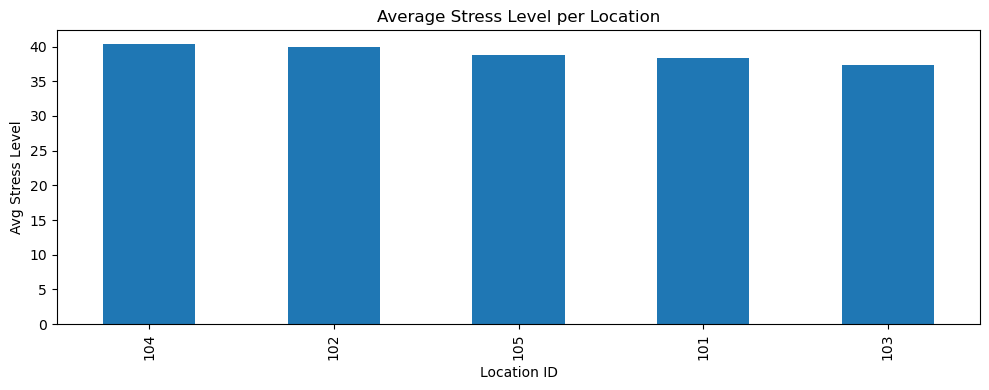

In [47]:
# Plot
avg_stress_per_location.plot(kind="bar", figsize=(10, 4), title="Average Stress Level per Location")
plt.ylabel("Avg Stress Level")
plt.xlabel("Location ID")
plt.tight_layout()
plt.show()

Visually, it does not seem that there is any difference in average stress level per location. However, to confirm this question, we conduct a One-Way ANOVA to find any significant difference between the location.

Before conducting the test, we formulate the following hypothesis:<br>
$H_0$ (null hypothesis):  The mean student stress levels is equal when grouped according to location<br>
$H_A$ (alternative  hypothesis): At least one group's mean student stress levels deviates when grouped according to location

f_oneway is used to conduct a one-way ANOVA test then the dataframe is grouped by location_id. After grouping the dataframe by location_id, a list of arrays is created which contains the stress levels per location_id. Finally, the results are printed.

In [48]:
from scipy.stats import f_oneway

grouped = [group['stress_level'].values for _, group in mental_health_df.groupby('location_id', observed=False)]
f_stat, p_value = f_oneway(*grouped)
print(f"F stat: {f_stat}")
print(f"P value: {p_value}")

F stat: 1.523737782611758
P value: 0.1931159606314366


Based on F-Statistic (1.5237), p-value is 0.19. Since the p-value is greater than the significance level (0.5), we __fail to reject the null hypothesis__. Thus, there is no sufficient evidence to prove that at least one location group is different from others. Concluding that __certain locations do not show higher stress levels regardless of environmental conditions.__

## __RESEARCH QUESTION 2:__ How does sleep duration interact with environmental conditions to influence student mood scores, and can specific thresholds of sleep be identified that buffer against negative environmental effects?

EDA:

### __2.1 How does sleep duration vary across different levels of environmental stressors?__

In [49]:
environmental_vars = ['temperature_celsius', 'humidity_percent', 'air_quality_index', 
                     'noise_level_db', 'lighting_lux', 'crowd_density']

correlations = []

for env_var in environmental_vars:
    env_sleep_corr = mental_health_df[env_var].corr(mental_health_df['sleep_hours'])
    
    correlations.append({
        'Environmental_Factor': env_var,
        'Environment_Sleep_Correlation': round(env_sleep_corr, 3)
    })

corr_df = pd.DataFrame(correlations)
print(corr_df)

  Environmental_Factor  Environment_Sleep_Correlation
0  temperature_celsius                          0.025
1     humidity_percent                          0.017
2    air_quality_index                         -0.240
3       noise_level_db                         -0.115
4         lighting_lux                         -0.020
5        crowd_density                         -0.079


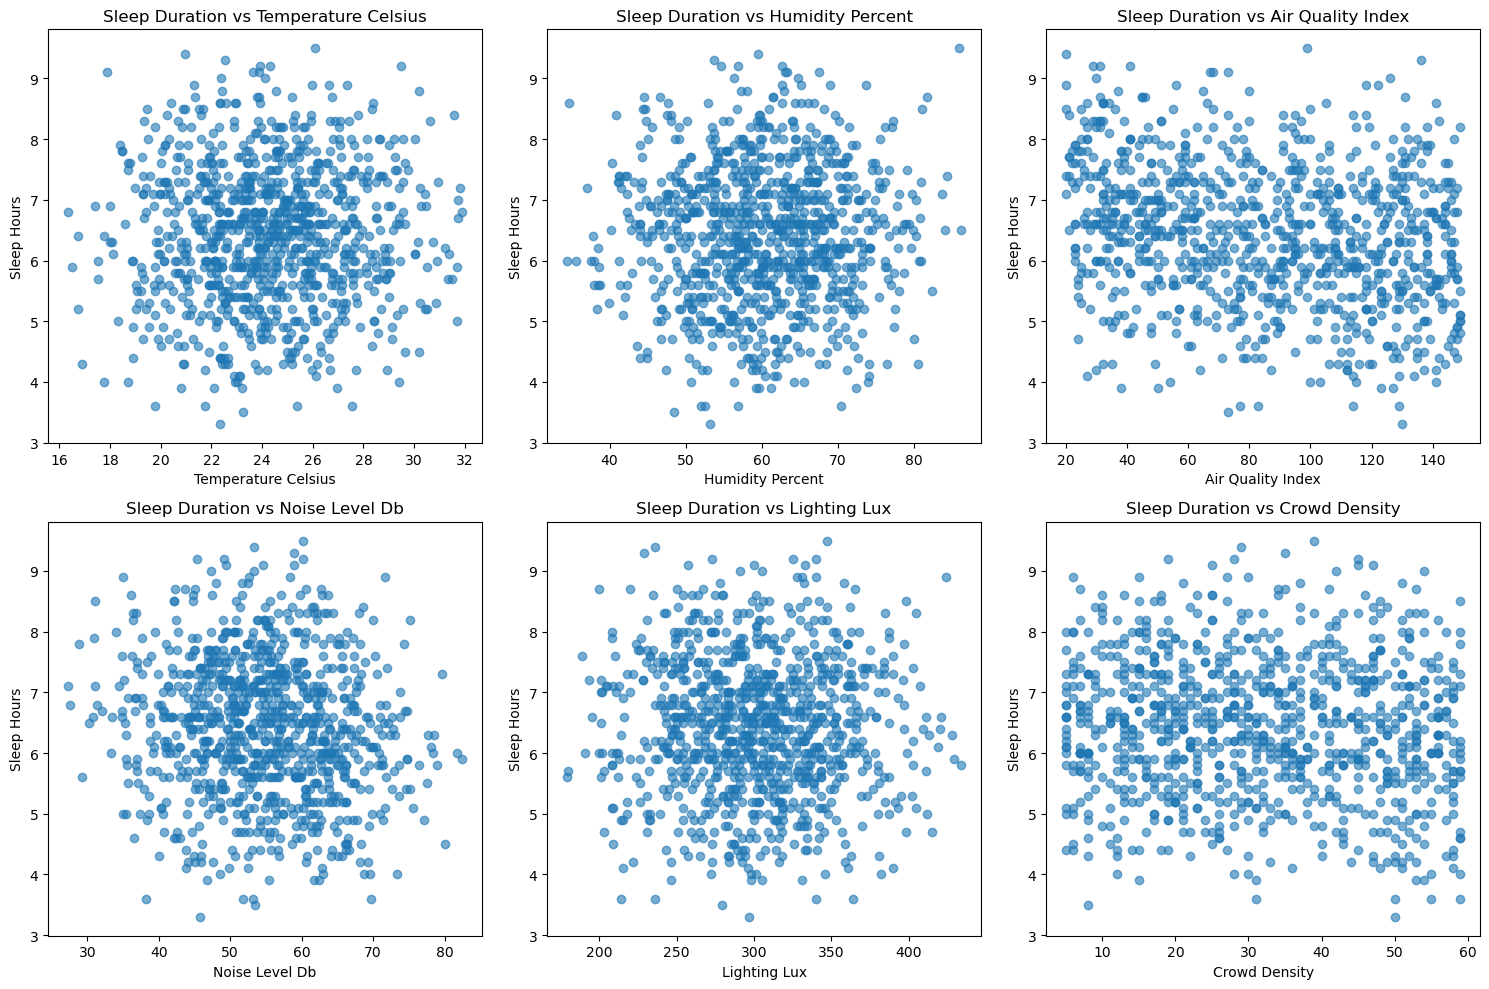

In [50]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, env_var in enumerate(environmental_vars):
    ax = axes[i]
    ax.scatter(mental_health_df[env_var], mental_health_df['sleep_hours'], alpha=0.6)
    ax.set_xlabel(env_var.replace('_', ' ').title())
    ax.set_ylabel('Sleep Hours')
    ax.set_title(f'Sleep Duration vs {env_var.replace("_", " ").title()}')

plt.tight_layout()
plt.show()

The analysis, combining both scatter plot visualizations and correlation data, indicates that there is no strong linear relationship between sleep duration and any single environmental factor. Most data points are concentrated around 6 to 8 hours of sleep across all variables—temperature, humidity, air quality, noise level, lighting, and crowd density—suggesting that sleep duration remains relatively stable despite fluctuations in these conditions. This visual trend is supported by the low correlation values, with all factors showing weak associations with sleep duration. The only moderately notable relationship is a negative correlation between air quality index and sleep duration (−0.240), implying that poorer air quality may slightly reduce sleep duration. Noise level (−0.115) and crowd density (−0.079) also show minor negative associations, while temperature (0.025), humidity (0.017), and lighting (−0.020) have negligible effects. Overall, the findings suggest that while environmental conditions may have some influence—especially in the case of air quality—their individual impact on sleep duration is generally limited, and sleep is likely shaped by a more complex interplay of factors beyond the environment alone.

### __2.2 What distinct environmental-sleep pattern clusters emerge from the data, and what characterizes each cluster?__

In [51]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

env_vars = ['temperature_celsius', 'humidity_percent', 'air_quality_index', 
           'noise_level_db', 'lighting_lux', 'crowd_density']

scaler = StandardScaler()
env_scaled = scaler.fit_transform(mental_health_df[env_vars])

kmeans = KMeans(n_clusters=3, random_state=42)
mental_health_df['env_cluster'] = kmeans.fit_predict(env_scaled)

sleep_by_cluster = mental_health_df.groupby('env_cluster')['sleep_hours'].agg(['mean', 'std', 'count'])
print(sleep_by_cluster)

                 mean       std  count
env_cluster                           
0            6.278361  1.130611    305
1            6.736313  1.139767    358
2            6.199317  1.068990    293


d:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [52]:
clustering_features = ['sleep_hours'] + env_vars
cluster_data = scaler.fit_transform(mental_health_df[clustering_features])
kmeans_sleep = KMeans(n_clusters=4, random_state=42)
mental_health_df['sleep_env_cluster'] = kmeans_sleep.fit_predict(cluster_data)

d:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


While clusters were formed using all environmental variables, we visualize using air quality index as it showed the strongest correlation with sleep duration (-0.240) in our previous analysis.

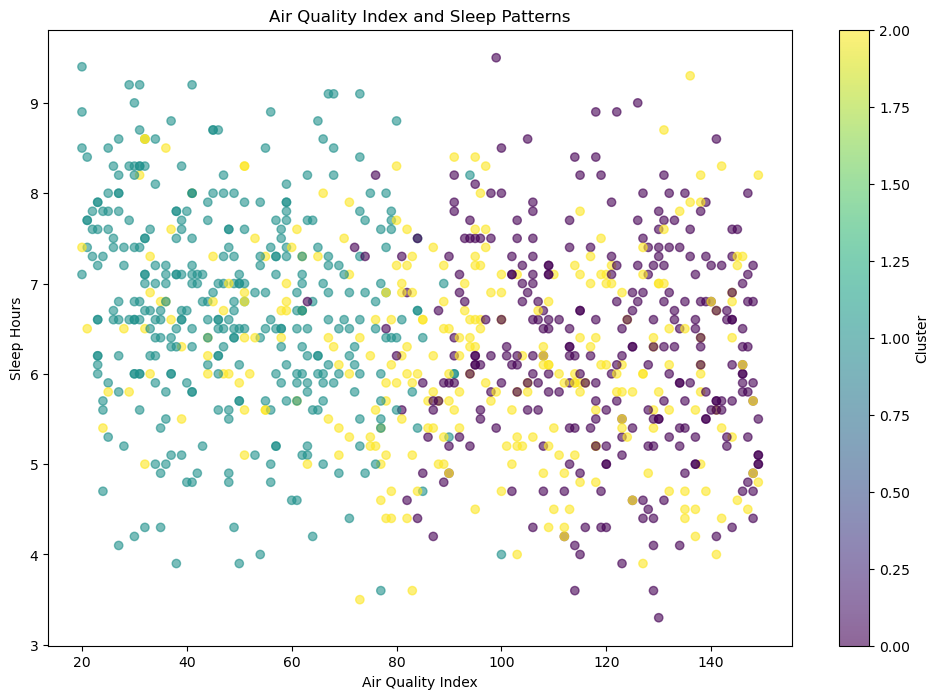

In [53]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(mental_health_df['air_quality_index'], 
                     mental_health_df['sleep_hours'],
                     c=mental_health_df['env_cluster'], 
                     cmap='viridis', alpha=0.6)
plt.xlabel('Air Quality Index')
plt.ylabel('Sleep Hours')
plt.title('Air Quality Index and Sleep Patterns')
plt.colorbar(scatter, label='Cluster')
plt.show()

The analysis reveals that environmental factors have weak relationships with sleep duration, with the strongest correlation being air quality index at -0.240. Due to these weak correlations, no specific environmental thresholds can be reliably identified that significantly impact student sleep patterns. While clustering analysis shows distinct environmental profiles, the limited correlation strength suggests that sleep duration is likely influenced by factors beyond the environmental conditions measured in this dataset. Campus location also shows no significant difference in sleep duration patterns.

### __2.3 Does sleep duration differ across different campus locations?__

Before conducting the test, we formulate the following hypotheses:

$H_0$ (null hypothesis): The sleep duration is not significantly different across all campus locations.

$H_A$ (alternative hypothesis): The mean mood score is significantly different across all campus locations.

Sleep Duration by Location:
                 mean       std  count
location_id                           
101          6.423902  1.150944    205
102          6.361111  1.149223    180
103          6.593296  1.112776    179
104          6.415306  1.163051    196
105          6.343878  1.119255    196


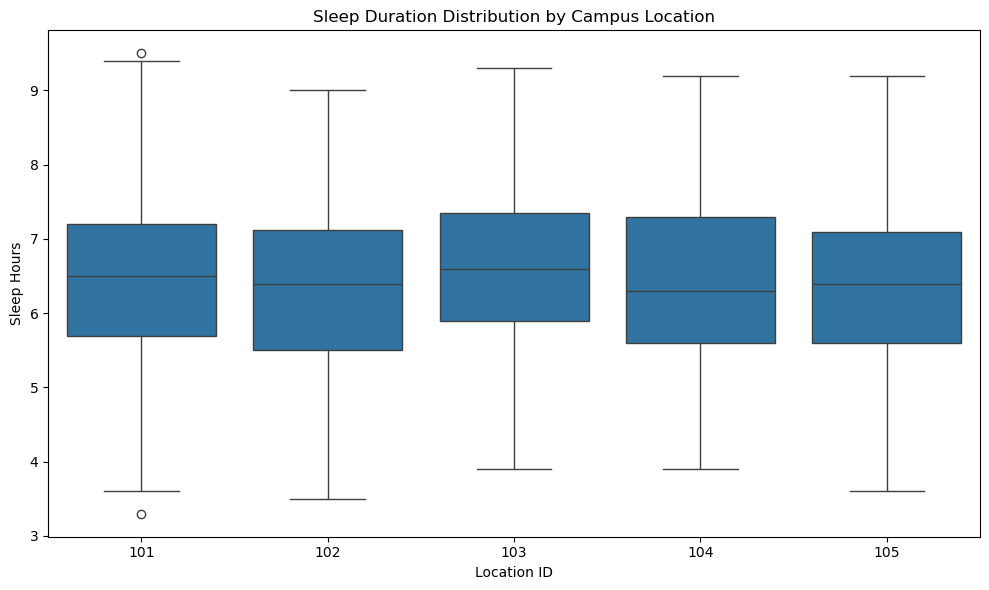

F stat: 1.3691604560264699
P value: 0.24267486179166456


In [54]:
sleep_by_location = mental_health_df.groupby('location_id', observed=True)['sleep_hours'].agg(['mean', 'std', 'count'])
print("Sleep Duration by Location:")
print(sleep_by_location)

plt.figure(figsize=(10, 6))
sns.boxplot(data=mental_health_df, x='location_id', y='sleep_hours')
plt.title('Sleep Duration Distribution by Campus Location')
plt.xlabel('Location ID')
plt.ylabel('Sleep Hours')
plt.tight_layout()
plt.show()

from scipy.stats import f_oneway

grouped_sleep = [group['sleep_hours'].values for _, group in mental_health_df.groupby('location_id', observed=False)]
f_stat, p_value = f_oneway(*grouped_sleep)
print(f"F stat: {f_stat}")
print(f"P value: {p_value}")

Based on the one-way ANOVA results (F-statistic = 1.37, p-value = 0.243), we fail to reject the null hypothesis at the 0.05 significance level. This indicates that there is no statistically significant difference in sleep duration across different campus locations.

Key Findings:
- Sleep duration remains relatively consistent across all five campus locations (101-105)
- The p-value of 0.243 is well above the significance threshold of 0.05
- Location-specific factors do not appear to significantly influence student sleep patterns

Implication for Research Question 2: This finding supports the broader conclusion that environmental factors have limited impact on sleep duration. Since sleep duration doesn't vary significantly by location, and locations represent different environmental contexts, this reinforces that:

Sleep duration is relatively stable across different campus environments
Environmental factors measured in this study (temperature, humidity, air quality, noise, lighting, crowd density) do not create location-specific sleep disruptions
Individual factors (personal sleep habits, academic schedules, lifestyle choices) likely play a more significant role in determining sleep duration than environmental conditions
Overall: The analysis confirms that campus location is not a significant predictor of sleep duration, aligning with the weak environmental correlations found in previous analyses and suggesting that sleep patterns are primarily driven by factors beyond the measured environmental conditions.

## __RESEARCH QUESTION 3:__ What combination of environmental conditions differentiates locations with higher rates of mental health risk (status 1-2) from those with predominantly normal status (0), and can these patterns inform university space design?

EDA:

### __3.1 What are the average values of environmental variables in locations where mental health status is at risk (1) vs. normal (0)?__
The average values of environmental variables were analyzed by filtering the mental_health_df dataset to include only records where mental health status is either 0 (normal) or 1 (at risk). The results show how these environmental conditions vary across different locations and mental health categories.

In [55]:
#filter mental health status 0 and 1 only
filtered_mental_health_df = mental_health_df[mental_health_df['mental_health_status'].isin([0, 1])]

#get the mean per location and whether mental health status is == 1 or 0
#env_vars is called to get the mean
mean_env_status = (
    filtered_mental_health_df.groupby(['mental_health_status', 'location_id'], observed=True)[env_vars]
    .mean()
    #To make the organize the tables better visually
    .reset_index()
)

mean_env_status

,mental_health_status,location_id,temperature_celsius,humidity_percent,air_quality_index,noise_level_db,lighting_lux,crowd_density
0,0,101,24.143741,59.436020,65.574074,52.667385,300.074074,28.879630
1,0,102,24.201128,60.216604,73.779070,53.140467,299.220930,27.988372
2,0,103,24.407478,59.629510,67.098039,52.097412,306.029412,31.558824
3,0,104,24.791617,61.375492,72.787234,53.025428,304.319149,28.287234
4,0,105,24.534268,60.852836,62.577320,54.633349,297.134021,28.927835
5,1,101,23.747176,60.212825,102.865979,56.484983,295.536082,32.855670
6,1,102,24.603232,59.723789,103.516129,57.278603,294.634409,35.806452
7,1,103,24.318811,60.579698,98.280000,54.965835,312.680000,33.106667
8,1,104,24.115111,60.223920,100.594059,56.011889,296.900990,34.554455
9,1,105,23.816813,60.120077,108.867347,56.721393,306.938776,34.887755


The next step is to create a for loop that goes through each variable, then it must be ensured that mental_health_status is treated as a category and remove unused categories. This is done to ensure that only statuses 0 and 1 appear in the legend and plots. Finally, a barplot is created for each environment variable showing its average effects on each location.

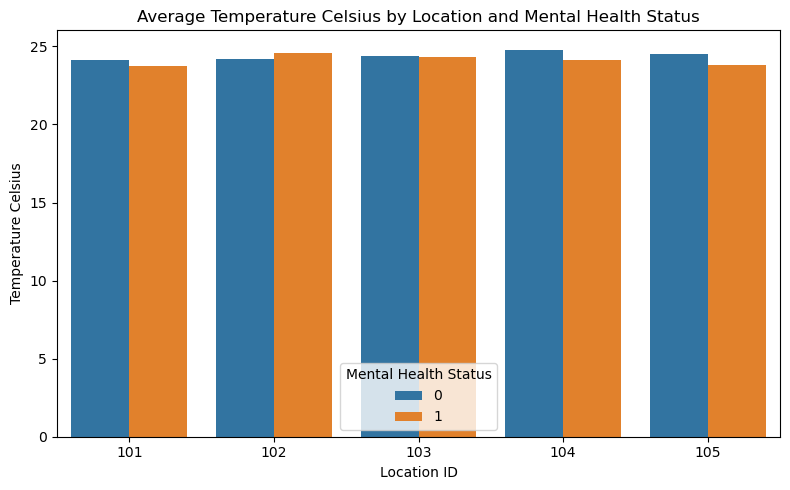

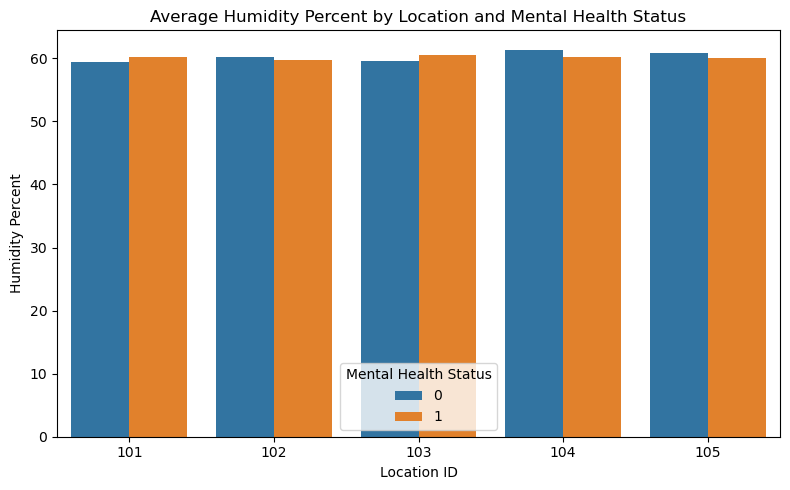

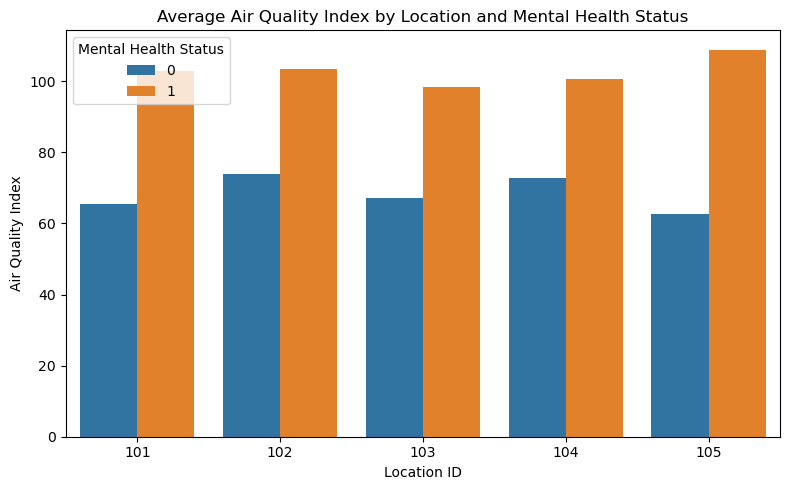

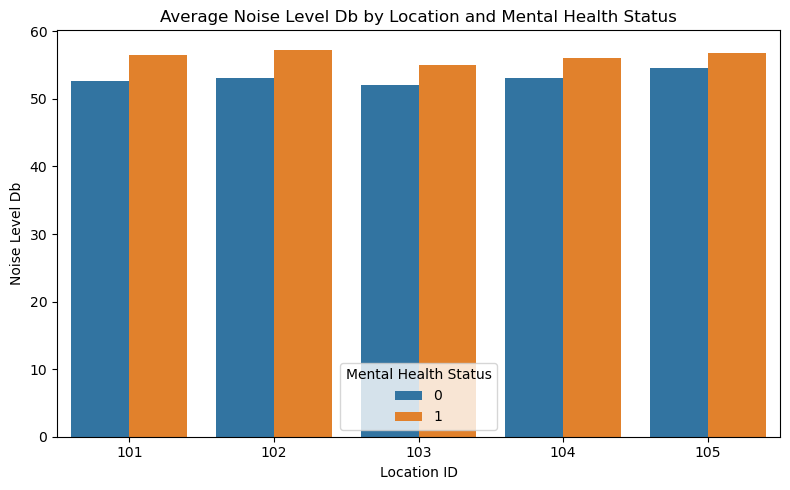

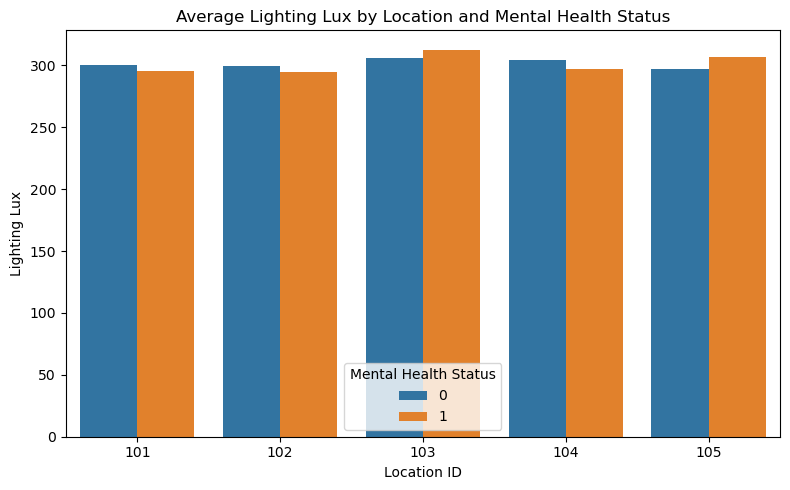

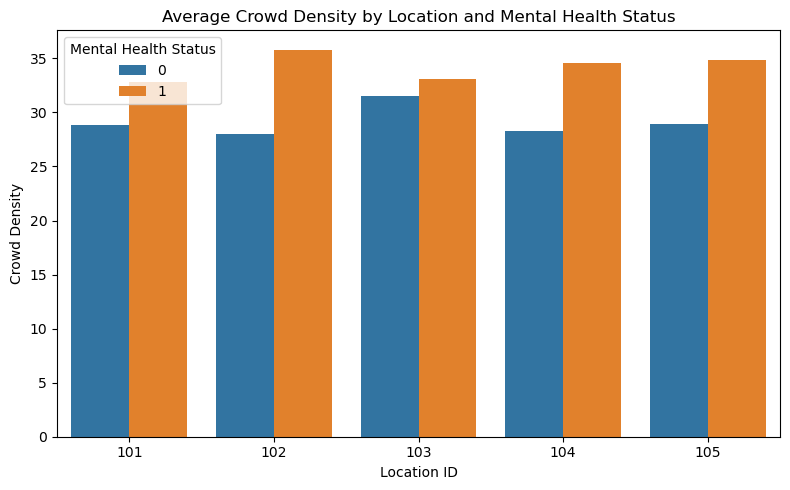

In [56]:
#show output of the aves per location while mental health status is == 1 or 0
for var in env_vars:
    #include only 0 and 1 in the legend (2 is unused so remove) 
    mean_env_status['mental_health_status'] = mean_env_status['mental_health_status'].astype('category')
    mean_env_status['mental_health_status'] = mean_env_status['mental_health_status'].cat.remove_unused_categories()
    #visualize per environmental variables
    plt.figure(figsize=(8, 5))
    sns.barplot(data=mean_env_status, x='location_id', y=var, hue='mental_health_status')
    plt.title(f'Average {var.replace("_", " ").title()} by Location and Mental Health Status')
    plt.ylabel(var.replace("_", " ").title())
    plt.xlabel('Location ID')
    plt.legend(title='Mental Health Status')
    plt.tight_layout()
    plt.show()

To summarize the given graphs comparing the averages of the two mental health statuses in different environmental variables per location:

| **Environmental Variable** | **Observation** | **Possible Mental Health Implication** |
|-----------------------------|------------------------------------------------|----------------------------------------------------------------------------------|
| **temperature_celsius**        | Fairly similar between groups across locations | No strong correlation observed with mental health risk |
| **humidity_percent**            | Slightly higher for status 1 in some locations | Mild humidity increase may be linked to discomfort or stress |
| **air_quality_index**       | Significantly higher for status 1 across all locations | Poor air quality appears strongly associated with at-risk mental health |
| **noise_level_db**        | Higher for status 1 in every location | Elevated noise levels may contribute to worsening one's mental health |
| **lighting_lux**          | Mixed results, slightly lower in some at-risk cases | Possible link to reduced exposure to natural light (mood impact) |
| **crowd_density**           | Consistently higher for mental health status 1 | Dense environments may contribute to worsening one's mental health |

### __3.2 Which locations have the highest proportion of at-risk mental health statuses?__ (where mental_health_status == 1)
The first step for this analysis is to count how many people there are at each location, then count how many of them have mental_health_status == 1. This is done to see how many people have at-risk mental health status per location. The next step is to divide the number of people with at-risk mental health status by the total number of people in each location to get the risk proportion. It is ensured that the columns are renamed so that it would be easier to read. Lastly, the values are sorted from highest to lowest to see which location had the most at-risk status.

In [57]:
total_counts = mental_health_df.groupby('location_id', observed=True)['mental_health_status'].count()

at_risk_counts = (
    mental_health_df[mental_health_df['mental_health_status'] == 1]
    .groupby('location_id', observed=True)['mental_health_status'].count()
)

risk_proportion = (at_risk_counts / total_counts).fillna(0).reset_index()
risk_proportion.columns = ['location_id', 'at_risk_proportion']


risk_proportion = risk_proportion.sort_values(by='at_risk_proportion', ascending=True)

risk_proportion

,location_id,at_risk_proportion
2,103,0.418994
0,101,0.473171
4,105,0.500000
3,104,0.515306
1,102,0.516667


This code below is for creating a barplot to help visualize the data on which location had the most at-risk health status proportion.

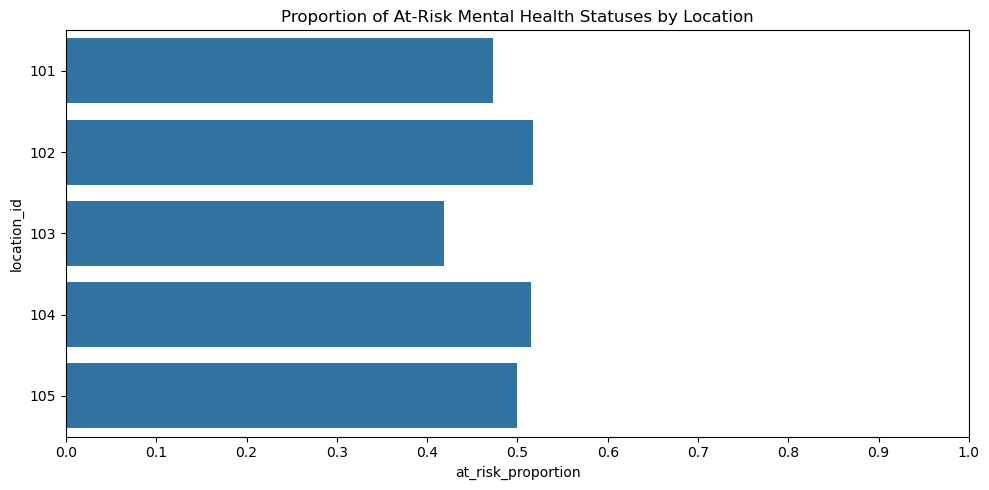

In [58]:
#show output as horizontal graph
plt.figure(figsize=(10, 5))
sns.barplot(data=risk_proportion, x='at_risk_proportion', y='location_id')
plt.title('Proportion of At-Risk Mental Health Statuses by Location')
plt.xlabel('at_risk_proportion')
plt.ylabel('location_id')
plt.xlim(0, 1)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.tight_layout()
plt.show()

**Overall**

It can be seen based on the graph that the proportions range from approximately 0.43 to 0.52, and the locations with the highest at-risk status are locations 104, 102, and 105. It can be seen as well that the mental health across all locations has a consistent presence of mental health concerns.


### __3.3 Which environmental factors show significant differences between at-risk and normal mental health status?__

Given that filtered_mental_health_df was already created in section 3.1 to only include mental health statuses that are 0 and 1, it is reused for this section to compare the average environmental values between the two groups. This performs an unpaired t-test to compare the means of various environmental factors between two groups: those with normal mental health status and those at risk. It separates the data into the respective groups, calculates the t-statistic and p-value for each factor, and stores the results in a dictionary. Finally, displays the t-statistic and p-value for each environmental variable to determine if any factors show significant differences between the two groups.

In [63]:
from scipy import stats
env_vars = ['air_quality_index', 'crowd_density', 'noise_level_db', 
            'humidity_percent', 'temperature_celsius', 'lighting_lux']

t_results = {}

for var in env_vars:
    normal_group = filtered_mental_health_df[filtered_mental_health_df['mental_health_status'] == 0][var]
    atrisk_group = filtered_mental_health_df[filtered_mental_health_df['mental_health_status'] == 1][var]
    
    t_stat, p_value = stats.ttest_ind(normal_group, atrisk_group)
    
    t_results[var] = {'t-statistic': t_stat, 'p-value': p_value}

for var, result in t_results.items():
    print(f"{var}: t-statistic = {result['t-statistic']:.2f}, p-value = {result['p-value']:.4f}")

air_quality_index: t-statistic = -15.99, p-value = 0.0000
crowd_density: t-statistic = -5.07, p-value = 0.0000
noise_level_db: t-statistic = -5.19, p-value = 0.0000
humidity_percent: t-statistic = 0.19, p-value = 0.8514
temperature_celsius: t-statistic = 1.61, p-value = 0.1067
lighting_lux: t-statistic = 0.19, p-value = 0.8523


The code performs hypothesis testing on several environmental variables and applies the Bonferroni correction to control for Type I errors when conducting multiple comparisons. It calculates an adjusted significance level (adjusted_alpha) by dividing the original alpha (0.05) by the number of environmental variables. The code then identifies and displays only those variables whose p-values are less than the adjusted threshold, listing their t-statistics and p-values as significant results.

In [64]:
# Adjust for multiple comparisons using Bonferroni correction
alpha = 0.05
adjusted_alpha = alpha / len(env_vars)  # Bonferroni correction
significant_vars = {var: res for var, res in t_results.items() if res['p-value'] < adjusted_alpha}

# Display significant results
print("Significant Variables after Bonferroni correction:")
for var, result in significant_vars.items():
    print(f"{var}: t-statistic = {result['t-statistic']:.2f}, p-value = {result['p-value']:.4f}")


Significant Variables after Bonferroni correction:
air_quality_index: t-statistic = -15.99, p-value = 0.0000
crowd_density: t-statistic = -5.07, p-value = 0.0000
noise_level_db: t-statistic = -5.19, p-value = 0.0000


A horizontal bar plot visualizes the p-values for each environmental factor. The red dashed line represents the Bonferroni-adjusted p-value threshold. Factors with p-values below this threshold are considered statistically significant.

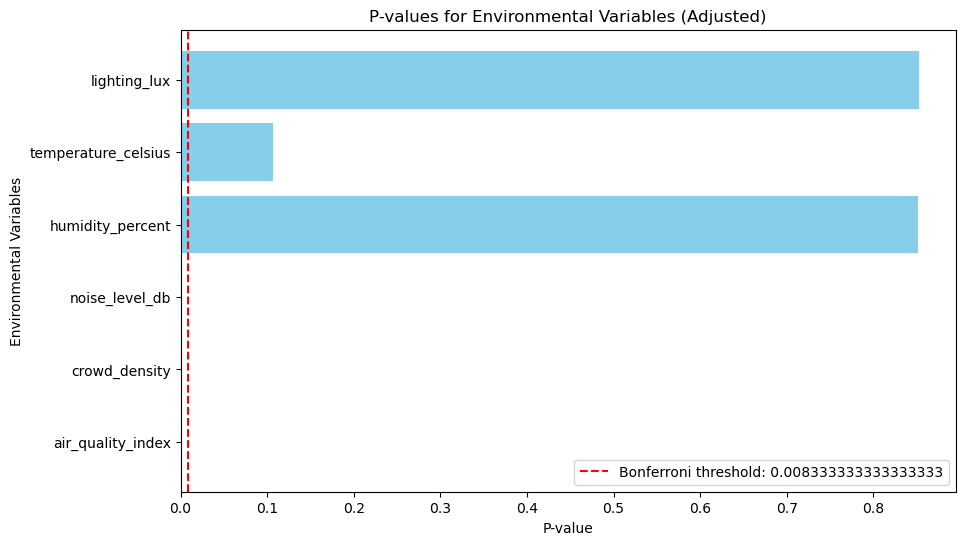

In [65]:
#Graph Representation
p_values = [result['p-value'] for result in t_results.values()]
variables = list(t_results.keys())

plt.figure(figsize=(10, 6))
plt.barh(variables, p_values, color='skyblue')
plt.axvline(x=adjusted_alpha, color='red', linestyle='--', label=f"Bonferroni threshold: {adjusted_alpha}")
plt.title('P-values for Environmental Variables (Adjusted)')
plt.xlabel('P-value')
plt.ylabel('Environmental Variables')
plt.legend()
plt.show()

The key findings of 3.3 indicate that air_quality_index, crowd_density, and noise_level_db are statistically significant variables, as their p-values are below the Bonferroni-adjusted threshold of 0.0083. This suggests that these environmental factors have a meaningful impact on the mental health status being analyzed. On the other hand, lighting_lux, temperature_celsius, and humidity_percent have p-values above the threshold, meaning they are not statistically significant in this analysis. This implies that these factors do not exhibit a significant relationship with mental health status after adjusting for multiple comparisons.


### __3.4 Which environmental conditions often happen together in places where students are mostly at risk (mental health status 1 or 2)?__

The first step for the analysis is to filter people with mental_health_status of 1 and 2. A loop is then created which goes through each variable in the environment variable list. Inside the loop, the median of each variable for at risk is being found to be used to compare if it belongs to the high_variable group or low_variable group. A basket is then created for each observation, and then single items and item pairs are being counted on how many times they occur. After that process, an association rule is created to know how often and likely certain pairs would occur. Lastly, the top 20 most significant co-occurring environmental conditions ain at-risk environments are displayed based on their lift.

In [ ]:
from itertools import combinations
from collections import defaultdict

at_risk_df = mental_health_df[mental_health_df['mental_health_status'].isin([1, 2])]

highlow_env = pd.DataFrame()

#Gets the median for that variable in the filtered data then converts the value to 'high_envvariable' or 'low_envvariable' based on whether it’s above or below the median
for var in env_vars:
    median = at_risk_df[var].median()
    highlow_env[var] = at_risk_df[var].apply(lambda x: f"high_{var}" if x > median else f"low_{var}")

#turns into a set of items (basket method)
basket = highlow_env.apply(lambda row: set(row), axis=1).tolist()

item_counts = defaultdict(int)
pair_counts = defaultdict(int)

for data in basket:
    for item in data:
        item_counts[frozenset([item])] += 1
    for pair in combinations(data, 2):
        pair_counts[frozenset(pair)] += 1

total_data = len(basket)

rules = []

for pair, pair_count in pair_counts.items():
    items = list(pair)
    A, B = frozenset([items[0]]), frozenset([items[1]])
    
    support_pair = pair_count / total_data
    support_A = item_counts[A] / total_data
    support_B = item_counts[B] / total_data
    
    confidence_A_to_B = support_pair / support_A if support_A > 0 else 0
    lift = confidence_A_to_B / support_B if support_B > 0 else 0

    rules.append({
        'Rule': f"{list(A)[0]} → {list(B)[0]}",
        'Support': round(support_pair, 2),
        'Confidence': round(confidence_A_to_B, 2),
        'Lift': round(lift, 2)
    })

rules_df = pd.DataFrame(rules).sort_values(by='Lift', ascending=False)
rules_df.head(20)

,Rule,Support,Confidence,Lift
2,high_noise_level_db → low_air_quality_index,0.28,0.55,1.10
43,high_air_quality_index → low_noise_level_db,0.28,0.55,1.10
39,low_lighting_lux → high_air_quality_index,0.27,0.54,1.08
12,high_lighting_lux → low_air_quality_index,0.27,0.54,1.08
27,high_crowd_density → low_lighting_lux,0.26,0.54,1.07
11,high_temperature_celsius → low_humidity_percent,0.27,0.53,1.07
21,high_humidity_percent → low_temperature_celsius,0.27,0.53,1.07
37,high_crowd_density → low_noise_level_db,0.26,0.53,1.06
44,low_temperature_celsius → low_noise_level_db,0.27,0.53,1.06
31,high_humidity_percent → low_noise_level_db,0.26,0.53,1.06


Based on the output above the Lift values accordingly:

Lift = 1 → A and B occur together just as often as expected by chance (no strong relationship).

Lift > 1 → A and B occur together more often than expected → positive association.

Lift < 1 → A and B occur together less often than expected → negative or inverse relationship.

The code below generates a scatter plot that helps visualize the strength of the association rules

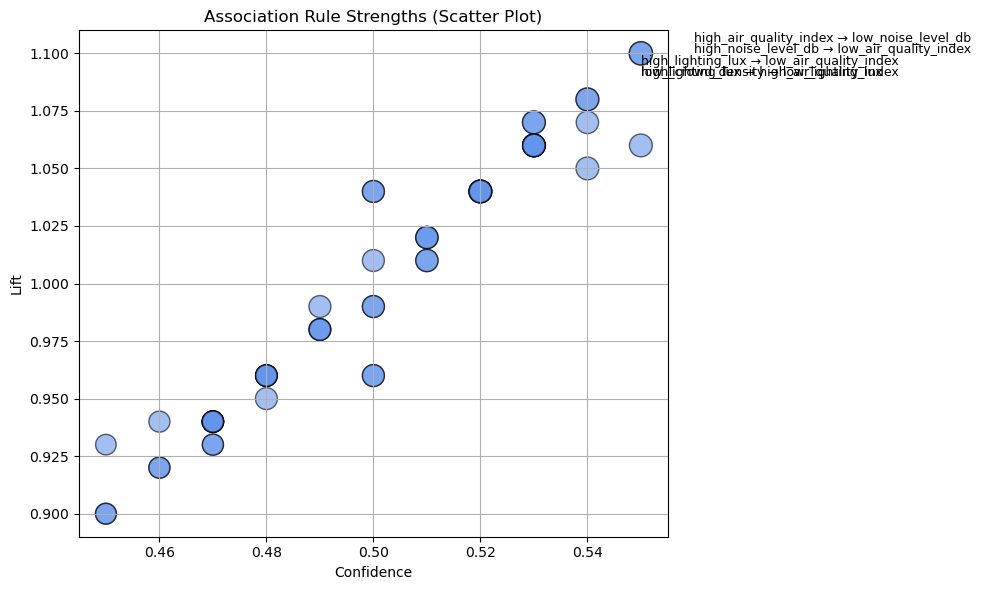

In [ ]:
x = rules_df['Confidence']
y = rules_df['Lift']
sizes = rules_df['Support'] * 1000
labels = rules_df['Rule']

plt.figure(figsize=(10, 6))
scatter = plt.scatter(x, y, s=sizes, alpha=0.6, c='cornflowerblue', edgecolors='black')

plt.xlabel('Confidence')
plt.ylabel('Lift')
plt.title('Association Rule Strengths (Scatter Plot)')

for i in range(min(5, len(rules_df))):
    plt.text(x.iloc[i] + 0.01, y.iloc[i] + (i * 0.005), labels.iloc[i], fontsize=9)

plt.grid(True)
plt.tight_layout()
plt.show()

**Key Findings of 3.3 and 3.4:**

In conclusion, both mean-based analysis and median-based association rule mining showed that crowd density, noise levels, and air quality are significant to the people's at-risk mental health concerns. It was shown that excessive noise levels results in poor air quality, and that air quality was the most dominant in the combinations when finding the top different combinations that are consistently associated with at-risk mental health status. According to these results, university environments could significantly improve students' mental health by improving ventilation, controlling noise, and minimizing crowding.


### __Generative AI Use Policy__
Statement: During the preparation of this work the author(s) used ChatGPT (OpenAI)
for the following purposes:

- Suggesting appropriate statistical tests to assist in answering the research questions.
- Suggest appropriate graphs for best visualization of data
- Suggest libraries (statsmodels, seaborn, numpy) and their appropriate functions to implement the tests in python

After using this tool/service, the author(s) reviewed and edited the content as needed and take(s) full responsibility for the content of the publication.